In [1]:
#importing all the libraries
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%time

!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt ./

Cloning into 'yolov5'...
remote: Enumerating objects: 14995, done.
remote: Total 14995 (delta 0), reused 0 (delta 0), pack-reused 14995
Receiving objects: 100% (14995/14995), 14.08 MiB | 17.93 MiB/s, done.
Resolving deltas: 100% (10280/10280), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.8 MB/s eta 0:00:00
CPU times: user 108 ms, sys: 56.1 ms, total: 164 ms
Wall time: 12.8 s


In [4]:
image_h, image_w, num_channels = (380, 676, 3)
df = pd.read_csv('/content/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/image_w
df['w'] = df['w']/image_w
df['y_center'] = df['y_center']/image_h
df['h'] = df['h']/image_h
df.head()
     

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [5]:
index = list(set(df.image_id))
img = random.choice(index)
print("Image ID: %s"%(img))
image = cv2.imread(f'/content/drive/MyDrive/training_images/training_images/{img}.jpg')
image.shape

Image ID: vid_4_8560


(380, 676, 3)

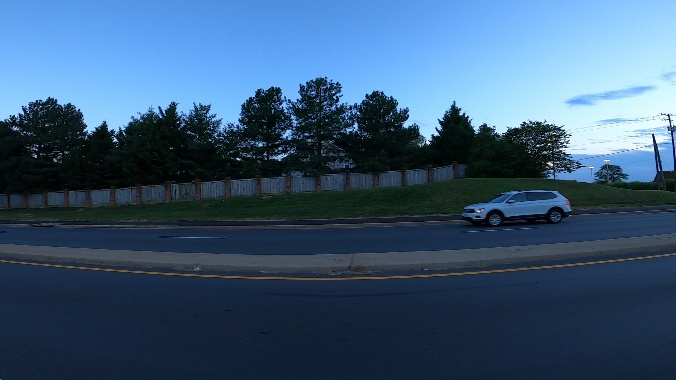

In [6]:
img = random.choice(index)
Image(filename=f'/content/drive/MyDrive/training_images/training_images/{img}.jpg',width=400)

In [7]:
src = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/drive/MyDrive/training_images/training_images/vid_4_1000.jpg".format(src,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/355 [00:00<?, ?it/s]

In [8]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/drive/MyDrive/training_images/training_images/ 

detect: weights=['yolov5/yolov5s.pt'], source=/content/drive/MyDrive/training_images/training_images/, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-71-gc442a2e Python-3.8.10 torch-1.13.1+cu116 CPU

100% 14.1M/14.1M [00:00<00:00, 186MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/1001 /content/drive/MyDrive/training_images/training_images/vid_4_1000.jpg: 416x704 1 car, 663.2ms
image 2/1001 /content/drive/MyDrive/training_images/training_images/vid_4_10000.jpg: 416x704 1 car, 391.8ms

In [9]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("yolov5/runs/detect/exp"):
    predicted_files.extend(filenames)

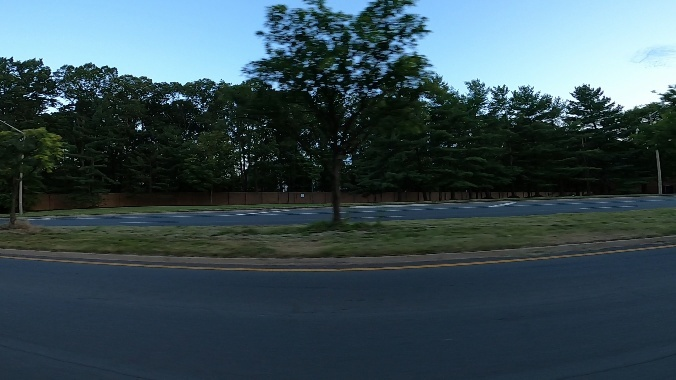

In [16]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

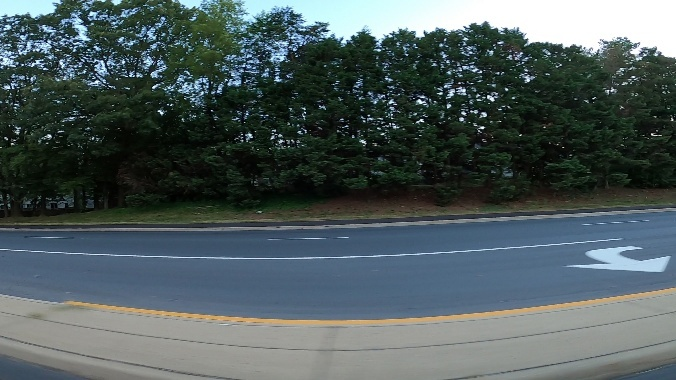

In [17]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

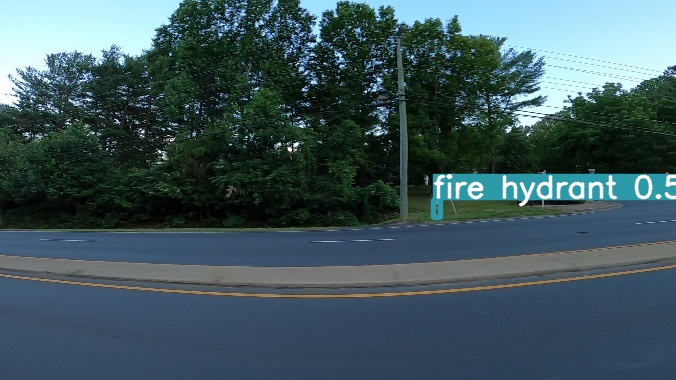

In [18]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

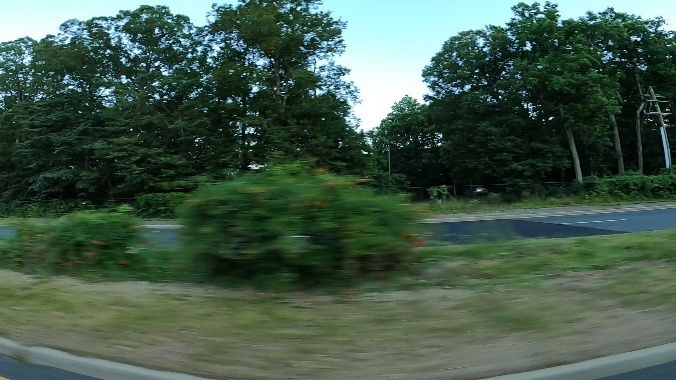

In [19]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

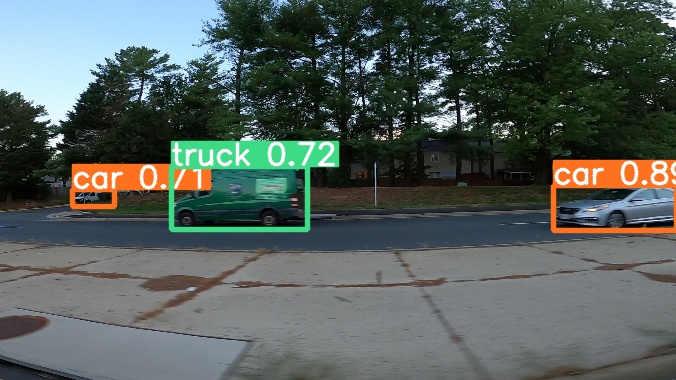

In [15]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

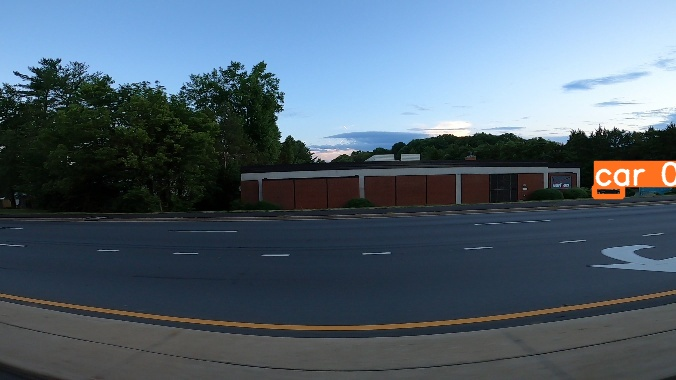

In [20]:
Image(filename=f'yolov5/runs/detect/exp/{random.choice(predicted_files)}')

In [ ]:
!rm -rf runs yolov5